# Import libraries and metrics

In [422]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict as dd

RESULTS_PATH = "results/"
CLIENTS_METRICS = "clients.json"
NODES_METRICS = "node%d.json"

PLOTS_OUT_PATH = "plots/"

with open(RESULTS_PATH + CLIENTS_METRICS, "r") as f:
    file = open(RESULTS_PATH + CLIENTS_METRICS)
    clients_metrics = list(map(lambda x: json.loads(x), file.readlines()))

nodes_metrics = {}
for i in range(1, 5):
    with open(RESULTS_PATH + NODES_METRICS % i, "r") as f:
        file = open(RESULTS_PATH + NODES_METRICS % i)
        nodes_metrics[i] = list(map(lambda x: json.loads(x), file.readlines()))


# Results

## Correctness Tests

### Correct Blockchain Order

In [423]:
# Check if 2f+1 nodes have the same number of blocks
num_blocks = {}
for i in range(1, 5):
    num_blocks[i] = len(list(filter(lambda x: x["metric"] == "committed_block", nodes_metrics[i])))
if len(set(num_blocks.values())) > 1:
    print("Different number of blocks in nodes")
    print(num_blocks)
else:
    print("All nodes have the same number of blocks: " + str(num_blocks[1]))

# Check if all nodes have the same blocks in same order
blocks = dd(dict)
for i in range(1, 5):
    for block in list(filter(lambda x: x["metric"] == "committed_block", nodes_metrics[i])):
        blocks[i][int(block["seq"])] = block["hash"]

for i in range(1, 5):
    for j in range(1, 5):
        for k in range(1, np.max(list(num_blocks.values())) + 1):
            try:
                if blocks[i][k] != blocks[j][k] and blocks[i][k]:
                    print("ERROR: Different blocks in nodes in seq=" + str(k))
                    print("Node " + str(i) + ": " + blocks[i][k])
                    print("Node " + str(j) + ": " + blocks[j][k])
                    pass
            except KeyError:
                continue

print("All nodes have the same blocks in same order")

Different number of blocks in nodes
{1: 50, 2: 152, 3: 152, 4: 152}
ERROR: Different blocks in nodes in seq=50
Node 1: 518e9068f908def7a6815f5623e4d0684e343cb46b364980eaeedd470cdc722d
Node 2: 374718e75f15e581cc13ef6f7c82e196cea767e3d2c2f3964a79ab2096aa4b41
ERROR: Different blocks in nodes in seq=50
Node 1: 518e9068f908def7a6815f5623e4d0684e343cb46b364980eaeedd470cdc722d
Node 3: 374718e75f15e581cc13ef6f7c82e196cea767e3d2c2f3964a79ab2096aa4b41
ERROR: Different blocks in nodes in seq=50
Node 1: 518e9068f908def7a6815f5623e4d0684e343cb46b364980eaeedd470cdc722d
Node 4: 374718e75f15e581cc13ef6f7c82e196cea767e3d2c2f3964a79ab2096aa4b41
ERROR: Different blocks in nodes in seq=50
Node 2: 374718e75f15e581cc13ef6f7c82e196cea767e3d2c2f3964a79ab2096aa4b41
Node 1: 518e9068f908def7a6815f5623e4d0684e343cb46b364980eaeedd470cdc722d
ERROR: Different blocks in nodes in seq=50
Node 3: 374718e75f15e581cc13ef6f7c82e196cea767e3d2c2f3964a79ab2096aa4b41
Node 1: 518e9068f908def7a6815f5623e4d0684e343cb46b364980eaee

## Simple Statistics

### Average Block Size

In [424]:
avg_block_size = np.mean(list(map(lambda x: int(x["num_ops"]), filter(lambda x: x["metric"] == "committed_block", nodes_metrics[1]))))
print("Average block size: " + str(avg_block_size) + " operations")

Average block size: 59.22 operations


### Average immediate reply time

In [425]:
avg_reply = np.mean(list(map(lambda x: int(x["latency"]), filter(lambda x: x["metric"] == "operation_reply", clients_metrics))))
print("Average reply time: " + str(avg_reply) + " ms")

Average reply time: 5.437357630979498 ms


### Average operation execution time

In [426]:
avg_exec = np.mean(list(map(lambda x: int(x["latency"]), filter(lambda x: x["metric"] == "operation_executed", clients_metrics))))
print("Average execution time: " + str(avg_exec) + " ms")

Average execution time: 309.07591222250574 ms


### Executed Operations Throughput

In [427]:
# calculate start and end
elapsed = int(clients_metrics[-1]["time"]) - int(clients_metrics[0]["time"])

# calculate number of blocks
num_blocks = len(list(filter(lambda x: x["metric"] == "operation_executed", clients_metrics)))

# calculate throughput
throughput = num_blocks / (elapsed / 1000)

print("Throughput: " + str(throughput) + " ops/s")

Throughput: 133.626568466994 ops/s


### Block Throughput

In [428]:
# calculate start and end
elapsed = int(nodes_metrics[3][-1]["time"]) - int(nodes_metrics[3][0]["time"])

# calculate number of blocks
num_blocks = len(list(filter(lambda x: x["metric"] == "committed_block", nodes_metrics[2])))

# calculate throughput
throughput = num_blocks / (elapsed / 1000)

print("Throughput: " + str(throughput) + " blocks/s")


Throughput: 2.656181738750546 blocks/s


## Plotting

### Latency Per Operation

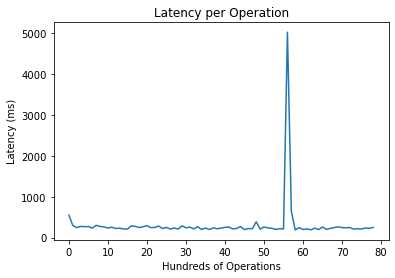

In [429]:
latencies = list(map(lambda x: int(x["latency"]), filter(lambda x: x["metric"] == "operation_executed", clients_metrics)))

# average of each 100 ops
avg_latencies = []
for i in range(0, len(latencies), 100):
    avg_latencies.append(np.mean(latencies[i:i+100]))


plt.plot(avg_latencies)
plt.ylabel("Latency (ms)")
plt.xlabel("Hundreds of Operations")
plt.title("Latency per Operation")
plt.savefig(PLOTS_OUT_PATH + "latency_per_operation.pdf")
plt.show()
